# Pre-trained object detection 

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
import keras_cv
from keras_cv import bounding_box, visualization
from keras_core import optimizers
import numpy as np
import resource
import os 
import tqdm

Using TensorFlow backend


/Users/frazerhogg/Development /Udemy/ML Computer Vision /Image Classification, Fine-Tuning, and Transerfer Learning/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
bb_format = 'xywh'

In [3]:
pretained_model = keras_cv.models.RetinaNet.from_preset(
    'retinanet_resnet50_pascalvoc',
    bounding_box_format=bb_format
)

In [4]:
pretained_model.summary()

Model: "retina_net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ images (InputLayer) │ (None, None,      │          0 │ -                 │
│                     │ None, 3)          │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ [(None, None,     │ 23,561,152 │ images[0][0]      │
│ (Functional)        │ None, 512),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 1024),      │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 2048)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ feature_pyramid     │ [(None, None,     │  7,997,440 │ functional[0][0], │
│ (FeaturePyramid)    │ None, 256),       │            │ functional[0][1], │
│                     │ (None, None,      │            │ functional[0][2]  │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256),       │            │                   │
│                     │ (None, None,      │            │                   │
│                     │ None, 256)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head_1   │ (None, None,      │  1,853,220 │ feature_pyramid[… │
│ (PredictionHead)    │ None, 36)         │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ prediction_head     │ (None, None,      │  2,185,140 │ feature_pyramid[… │
│ (PredictionHead)    │ None, 180)        │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
│                     │                   │            │ feature_pyramid[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_2 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_4 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_6 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_8 (Reshape) │ (None, None, 4)   │          0 │ prediction_head_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_1 (Reshape) │ (None, None, 20)  │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, None, 20)  │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_5 (Reshape) │ (None, None, 20)  │          0 │ prediction_head[… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 35,596,952 (135.79 MB)

 Trainable params: 35,543,832 (135.59 MB)

 Non-trainable params: 53,120 (207.50 KB)

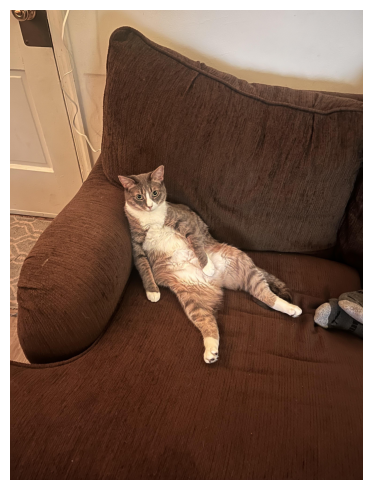

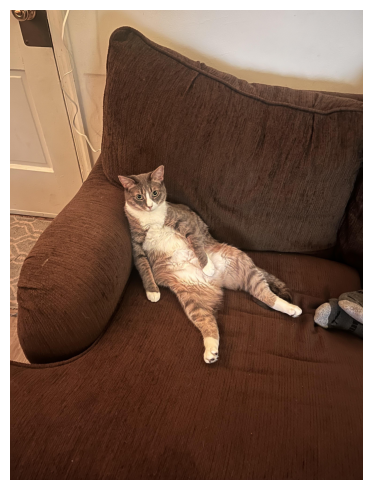

In [5]:
url = 'https://i.redd.it/twpfhcw58xgb1.jpg'
image = tf.keras.utils.get_file(origin=url)
image = tf.keras.utils.load_img(image)
image = np.array(image)
h, w, c = image.shape
batch = image.reshape(1, h, w, c)

visualization.plot_image_gallery(
    batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5
)

In [6]:
inference_resizing = keras_cv.layers.Resizing(
    height=640,
    width=640,
    pad_to_aspect_ratio=True,
    bounding_box_format=bb_format
)

In [7]:
image_batch = inference_resizing(batch)

In [8]:
label_names = [
    'aeroplane',
    'bicycle',
    'bird',
    'boat',
    'bottle',
    'bus',
    'car',
    'cat',
    'chair',
    'cow',
    'diningtable',
    'dog',
    'horse',
    'motorbike',
    'person',
    'pottedplant',
    'sheep',
    'sofa',
    'train',
    'tvmonitor'
]

In [9]:
id2label = {k: v for k, v in enumerate(label_names)}

In [10]:
id2label

{0: 'aeroplane',
 1: 'bicycle',
 2: 'bird',
 3: 'boat',
 4: 'bottle',
 5: 'bus',
 6: 'car',
 7: 'cat',
 8: 'chair',
 9: 'cow',
 10: 'diningtable',
 11: 'dog',
 12: 'horse',
 13: 'motorbike',
 14: 'person',
 15: 'pottedplant',
 16: 'sheep',
 17: 'sofa',
 18: 'train',
 19: 'tvmonitor'}

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


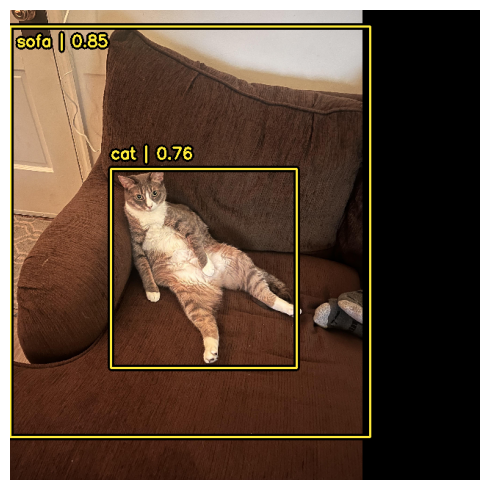

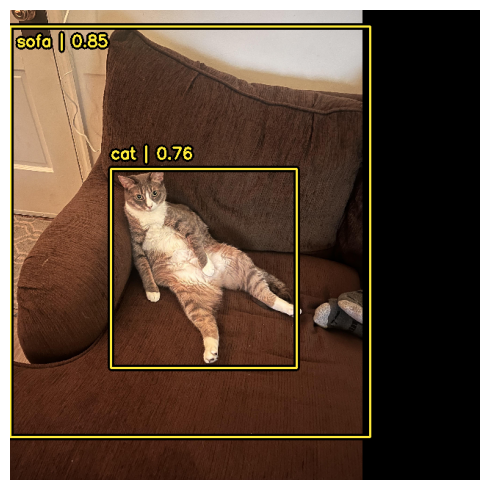

In [12]:
y_pred = pretained_model.predict(image_batch)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    bounding_box_format=bb_format,
    class_mapping=id2label
)

In [13]:
y_pred

{'boxes': array([[[ -0.88671875,  22.110718  , 491.30432   , 559.4436    ],
         [137.17673   , 216.78041   , 253.07513   , 270.2732    ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  -1.        ],
         [ -1.        ,  -1.        ,  -1.        ,  

# Non-Max Surpression

In [15]:
url = 'https://media.istockphoto.com/id/2157935001/photo/people-walking-and-cycling-to-work-in-washington-dc.jpg?s=612x612&w=0&k=20&c=Z_oVc-Wy3nccsDDwNnUGvb5OD8wgxsvMUddykn5bSos='
image = tf.keras.utils.get_file(origin=url)
image = tf.keras.utils.load_img(image)
image = np.array(image)
h, w, c = image.shape
batch = image.reshape(1, h, w, c)
image_batch = inference_resizing(batch)


63866/63866 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


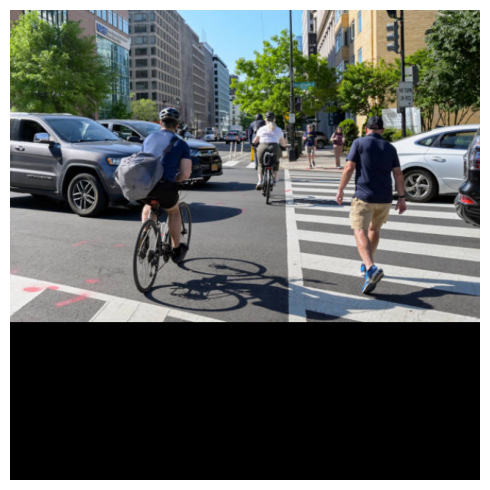

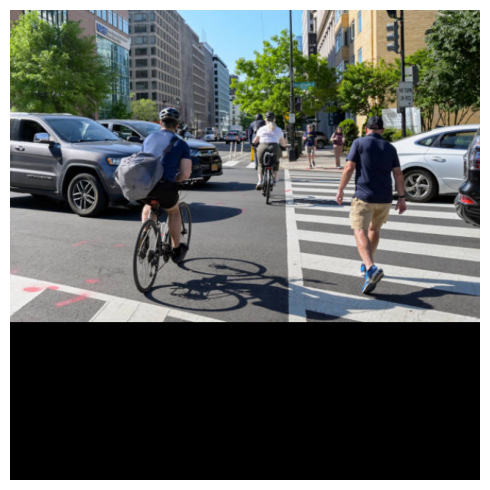

In [16]:
visualization.plot_image_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    scale=5
)

In [ ]:
prediction_decoder = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=bb_format,
    from_logits=True,
    iou_threshold=1.0,
    confidence_threshold=0.0 # When set to 0, all predictions are considered resulting in many bounding boxes
)


In [18]:
pretained_model.prediction_decoder = prediction_decoder

In [19]:
y_pred = pretained_model.predict(image_batch)

/Users/frazerhogg/Development /Udemy/ML Computer Vision /Image Classification, Fine-Tuning, and Transerfer Learning/.venv/lib/python3.12/site-packages/keras/src/models/functional.py:241: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: {'images': 'images'}
Received: inputs=Tensor(shape=(1, 640, 640, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step


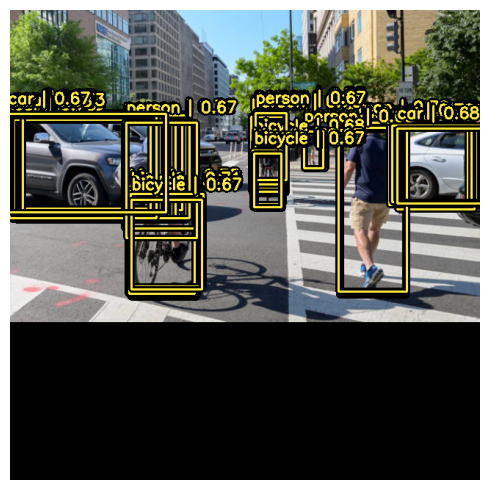

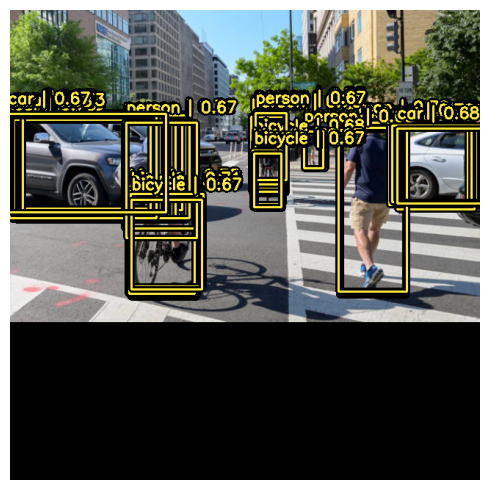

In [20]:
visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred,
    scale=5,
    font_scale=0.7,
    class_mapping=id2label,
    bounding_box_format=bb_format
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 683ms/step


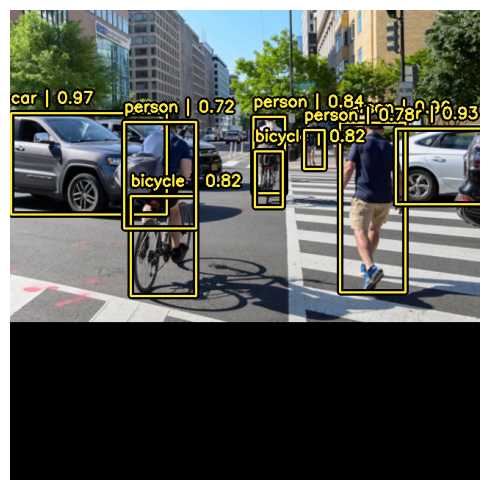

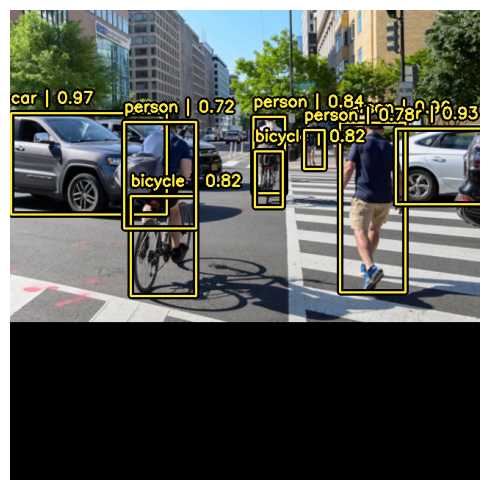

In [22]:
#  Try again, this time with different confidence threshold and iou threshold

prediction_decoder_2 = keras_cv.layers.MultiClassNonMaxSuppression(
    bounding_box_format=bb_format,
    from_logits=True,
    iou_threshold=0.2,
    confidence_threshold=0.7
)

pretained_model.prediction_decoder = prediction_decoder_2
y_pred_2 = pretained_model.predict(image_batch)

visualization.plot_bounding_box_gallery(
    image_batch,
    value_range=(0, 255),
    rows=1,
    cols=1,
    y_pred=y_pred_2,
    scale=5,
    font_scale=0.7,
    class_mapping=id2label,
    bounding_box_format=bb_format
)